# Estimating discrete choice models with Biogeme

This tutorial is available at: https://colab.research.google.com/drive/1a5wheL60vVlXnq_PxmmTL5Ky8ShyH3Ks?usp=sharing


Biogeme is a open source Python package designed for the maximum likelihood estimation of parametric models in general, with a special emphasis on discrete choice models. </br>
It is developed and maintained by **Prof. Michel Bierlaire**, Ecole Polytechnique Fédérale de Lausanne, Switzerland.</br>
Website: https://biogeme.epfl.ch/

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#!pip install biogeme==3.2.8 -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd

import biogeme.biogeme as bio
import biogeme.database as db
import biogeme.models as models
import biogeme.results as res

from biogeme.expressions import Beta
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(42)

## 1) Download Swissmetro data

* Dataset consists of survey data collected on the trains between St. Gallen and Geneva, Switzerland, during March 1998.
* Data is collected via interviews and mailbox surveys.
* There are three choice alternatives: **Rail, Swissmetro and Car**

Bierlaire, M., Axhausen, K. and Abay, G. (2001), The acceptance of modal innovation: The case of Swissmetro, in ‘Proceedings of the Swiss Transport Research Conference’, Ascona, Switzerland.

Find more about this dataset here: https://transp-or.epfl.ch/documents/technicalReports/CS_SwissmetroDescription.pdf

In [ ]:
# Download dataset from the web, convert to a dataframe
url = 'https://transp-or.epfl.ch/pythonbiogeme/examples/swissmetro/swissmetro.dat'
df = pd.read_table(url, sep='\t')
#df.to_csv("swissmetro.dat", sep='\t', index=False) # Uncomment to save to disk

In [ ]:
print(f"Number of rows in the dataset: {len(df)}")
print(f"Number of unique participants: {len(df.ID.unique())}")
df.sample(10, random_state=42)

Number of rows in the dataset: 10728
Number of unique participants: 1192


,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
592,2,0,1,66,1,1,1,2,1,2,...,206,85,30,118,92,30,0,108,91,2
608,2,0,1,68,1,1,1,2,1,2,...,116,42,60,77,48,20,1,78,35,3
424,2,0,1,48,1,0,6,3,1,3,...,54,2340,120,25,3380,20,1,32,67,1
10133,3,1,1,1126,4,1,1,1,1,3,...,336,122,60,84,150,10,0,216,165,2
5635,3,1,1,627,3,0,3,2,1,2,...,210,137,30,122,149,10,0,195,117,2
5466,3,1,1,608,3,0,3,1,1,2,...,183,95,60,83,116,10,0,208,136,2
9045,3,1,1,1006,4,0,1,1,1,5,...,144,50,120,89,54,20,0,143,70,2
5532,3,1,1,615,3,0,3,2,0,2,...,189,130,60,75,139,20,0,136,84,3
8898,3,1,1,989,4,0,1,1,1,3,...,158,46,60,113,56,20,0,88,52,3
7200,3,1,1,801,3,1,1,3,0,3,...,92,72,120,37,84,20,0,117,65,2


## 2) Data visualization

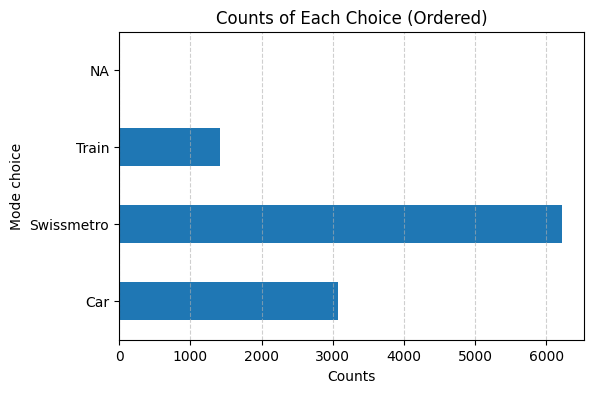

In [ ]:
# Categorize the travel purpose column
choice_order = [0, 1, 2, 3]
choice_labels = ['NA', 'Train', 'Swissmetro', 'Car']
categorical_choices = pd.Categorical(df['CHOICE'], categories=choice_order, ordered=True)

# Plot the counts of each purpose
plt.figure(figsize=(6, 4))
chart = categorical_choices.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('Mode choice')
plt.title('Counts of Each Choice (Ordered)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.yticks(range(len(choice_labels)), reversed(choice_labels))
plt.show()

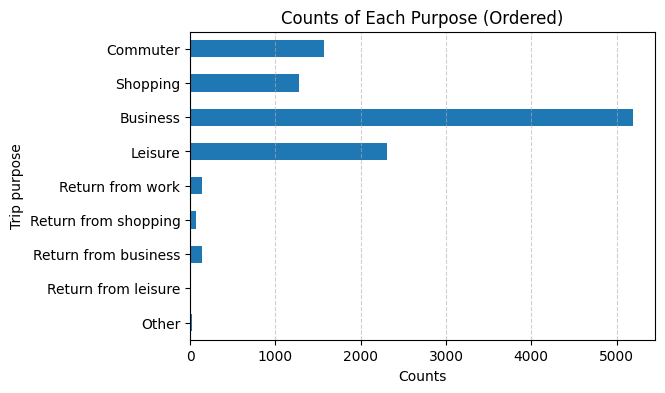

In [ ]:
# Categorize the travel purpose column
purpose_order = [1, 2, 3, 4, 5, 6, 7, 8, 9]
purpose_labels = ['Commuter', 'Shopping', 'Business', 'Leisure',
                  'Return from work', 'Return from shopping',
                  'Return from business', 'Return from leisure', 'Other']
categorical_purposes = pd.Categorical(df['PURPOSE'], categories=purpose_order, ordered=True)

# Plot the counts of each purpose
plt.figure(figsize=(6, 4))
chart = categorical_purposes.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('Trip purpose')
plt.title('Counts of Each Purpose (Ordered)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.yticks(range(len(purpose_labels)), reversed(purpose_labels))
plt.show()

## 3) Data preprocessing

### 3.1) Delete unwanted rows

In [ ]:
print(f"Number of observations before: {len(df)}")

# CHOICE=0 indicates unknown preference, let's delete them from our data.
df = df.drop(df[df['CHOICE'] == 0].index)

# For simplicity, let's retain only three travel purposes: 1 (Commuter), 3 (Business) and 4 (Leisure).
df = df.drop(df[~df['PURPOSE'].isin([1, 3, 4])].index)

print(f"Number of observations after: {len(df)}")

print(f"Unique mode choices in data: {sorted(df.CHOICE.unique())}")
print(f"Unique travel purposes in data: {sorted(df.PURPOSE.unique())}")

Number of observations before: 10728
Number of observations after: 9072
Unique mode choices in data: [np.int64(1), np.int64(2), np.int64(3)]
Unique travel purposes in data: [np.int64(1), np.int64(3), np.int64(4)]


### 3.2) Definition of new variables

In [ ]:
# If the traveler is a season ticket holder, the percieved monthly cost for the train and Swissmetro is set to the annual ticket cost.
# Let's make it zero, as travelers don't worry about the ticket price throughout the year after purchasing their annual pass.
# Reminder: GA = 0 means the traveler is not a season ticket holder
df['SM_CO'] = df.SM_CO * (df.GA == 0)
df['TRAIN_CO'] = df.TRAIN_CO * (df.GA == 0)

## 4) Data preparation

In [ ]:
# Similar to a machine learning task, let's partition our data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
database_train = db.Database("data/swissmetro", df_train)
database_test = db.Database("data/swissmetro", df_test)

print(f"Training partition has {database_train.getNumberOfObservations()} observations.")
print(f"Testing partition has {database_test.getNumberOfObservations()} observations.")

Training partition has 7257 observations.
Testing partition has 1815 observations.


**Use column names as global variables**

In [ ]:
globals().update(database_train.variables)

## 5) Model specification

Now we will derive a decision-making model from our data. Our model will *estimate* the influence of different factors on travelers' mode choices.

In this example, we limit our estimation for 2 attributes: time and financial cost.

### 5.1) Parameters to be estimated

We define parameter's using `Biogeme`'s `Beta` function. Usage:

```Beta(name, w, x, y, z)```

- Argument `name` is the parameter name, used for reporting.
- Argument `w` (*we set to 0*) is a default value, a starting point for estimation.
- Arguments `x, y` are the upper bound and lower bound.
- Argument `z`: if it is 0, the paramter will be estimated from data. If it is 1, it will be fixed to the default value.

First group of parameters are ASCs associated with each choice option.
- ASC stands for "Alternative Specific Constant".
- It is used to capture the average effect on utility of all factors that are not included in the model.
- We have 3 choices, so we define **2 ASCs "to be estimated"** and **one fixed to zero**.
- We do this so that we won't deal with infinite number of equilevent models. For details, page 24 of: https://eml.berkeley.edu/choice2/ch2.pdf

In [ ]:
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1) # Fixed to default value 0

Second group of parameters are **learnable** coefficients for attributes. These parameters will weigh each attribute for modeling the influence of different factors in human decision making.

Notice how both parameters are upper bounded by 0.

In [ ]:
B_TIME = Beta('B_TIME', 0, None, 0, 0) # Coefficient for travel time
B_COST = Beta('B_COST', 0, None, 0, 0) # Coefficient for financial cost of an option

### 5.2) Specify of the utility functions

Utility functions represent what we think humans **maximize** while making their mode choices. We have individual utilities associated with each choice.

In [ ]:
# Utility associated with mode train
V1 = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_CO

# Utility associated with mode Swissmetro
V2 = ASC_SM + B_TIME * SM_TT + B_COST * SM_CO

# Utility associated with mode private car
V3 = ASC_CAR + B_TIME * CAR_TT + B_COST * CAR_CO

# Define a dicstionary associating each option with a choice
utility_functions = {1: V1, # V1 is associated with choice 1 (Train)
                    2: V2, # V2 is associated with choice 2 (Swissmetro)
                    3: V3} # V3 is associated with option 3 (Private car)

Lastly, we need to take into account the availability of each option.

Swissmetro and train are available for all travelers, but not all travelers posses a private vehicle. For those observations who don't own a car, we only regard first two utility functions.

In [ ]:
availabilities = {1: TRAIN_AV,
                  2: SM_AV,
                  3: CAR_AV}

## 6) Building the model and estimation

Now we compute the choice probabilities using the *multinomial logit model*. For this example, we will use `loglogit` model from `Biogeme` to calculate the **log-likelihood** function.

This function returns the log-probabilities instead of raw probabilities to ensure numerical stability to prevent underflow when **multiplying small probabilities**.

The choice probabilities are computed as:
$$ P(i) = \frac{exp(V_i)}{sum(exp(V_j)}$$
for all available alternatives $j$, where $V_i$ is the systematic utility of alternative $i$.

Other models and their uses: https://transp-or.epfl.ch/biogeme-3.2.5/jupyter/Models.html

In [ ]:
logprob = models.loglogit(utility_functions, availabilities, CHOICE)

Now we can create the `BIOGEME` object to estimate our parameters.

In [ ]:
biogeme  = bio.BIOGEME(database_train, logprob, seed=42)
biogeme.modelName = "swissmetro_logit_train"

In [ ]:
results = biogeme.estimate()

Check the estimated parameters

In [ ]:
betaValues = results.getBetaValues()
for k, v in betaValues.items():
    print(f"{k:10}=\t{v:.3g}")

ASC_CAR   =	0.115
ASC_TRAIN =	-0.64
B_COST    =	-0.0116
B_TIME    =	-0.0142


See results in HTML

In [ ]:
biogeme.generateHtml = True
print(f"HTML file:    {results.data.htmlFileName}")

HTML file:    swissmetro_logit_train~21.html


## 7) Calculating choice probabilities with learned parameters

In [ ]:
simulate = {
           'Prob. train':  models.logit(utility_functions, availabilities, 1),
           'Prob. SM':  models.logit(utility_functions, availabilities, 2),
           'Prob. car': models.logit(utility_functions, availabilities, 3)
           }

biogeme = bio.BIOGEME(database_test, simulate, seed=42) # Now using test partition
biogeme.modelName = "swissmetro_logit_test"

**Use Betas obtained from training data to calculate choice probabilties for test data**

In [ ]:
simulatedValues = biogeme.simulate(betaValues)
# Create a prediction column, representing the choice for each row which we estimate with the highest probability
simulatedValues["prediction"] = simulatedValues.idxmax(axis=1).replace({'Prob. train': 1, 'Prob. SM': 2, 'Prob. car': 3})

In [ ]:
# Retrieve our test dataset partition
test_df = database_test.data.copy()

# Add probability and prediction columns to this dataframe
test_df = test_df.join(simulatedValues, how='left')

# Create a new row showing row-wise accuracy of our predictions
test_df['correct_prediction'] = test_df.apply(lambda row: row.CHOICE==row.prediction, axis=1)

# Calculate an accuracy score using this new column
print(f"Accuracy of the model: {test_df['correct_prediction'].value_counts().get(True)/len(test_df)}")

# Have a look at some correct/incorrect predictions
test_df.sample(10, random_state=42)

Accuracy of the model: 0.6931129476584023


,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,Prob. train,Prob. SM,Prob. car,prediction,correct_prediction
6569,3,1,1,730,3,1,1,2,0,4,...,10,0,144,110,2,0.048481,0.623711,0.327809,2,True
3495,2,0,1,389,3,1,7,1,1,5,...,20,0,112,320,1,0.291807,0.694692,0.013502,2,False
7807,3,1,1,868,3,1,3,2,0,3,...,30,0,200,195,2,0.061424,0.438981,0.499594,3,False
4861,3,1,1,541,3,0,1,0,0,3,...,10,0,117,65,2,0.173960,0.630383,0.195657,2,True
736,2,0,1,82,1,1,5,1,1,3,...,30,0,150,140,2,0.149099,0.692954,0.157947,2,True
3019,2,0,1,336,3,0,7,2,1,1,...,30,1,0,0,1,0.267068,0.732932,0.000000,2,False
5965,3,1,1,663,3,1,1,0,0,4,...,20,0,130,130,2,0.153385,0.680981,0.165634,2,True
4561,3,1,1,507,1,1,3,2,1,3,...,30,0,72,78,3,0.065272,0.170600,0.764128,3,True
10079,3,1,1,1120,4,1,1,1,0,4,...,10,0,96,75,3,0.049932,0.426339,0.523729,3,True
9200,3,1,1,1023,4,0,3,0,0,2,...,20,0,168,120,3,0.051276,0.690223,0.258500,2,False


# Exercises
1. In Section 3, we have filtered out dataset to only include observations with travel purpose 1 (Commuter), 3 (Business) and 4 (Leisure). Now, include also observations with purpose 2 (Shoppping).
2. Define a coefficient `B_AGE` for the `AGE` attribute and incorporate it in the utility functions. What is the problem with this approach?
3. Sensitivity of `AGE` will differ depending on the option. Instead of `B_AGE`, define 3 different coefficients (`B_AGE1`, `B_AGE2`, `B_AGE3`) for `AGE` and use one per each utility function insted of `B_AGE`.
4. Also, travelers might weigh cost differently when choosing between modes. Now define three coefficients for `COST` (`B_COST1`, `B_COST2`, `B_COST3`), and replace `B_COST` with them in the utilities.
5. We can involve certain assumptions in our modeling. Let's assume that *a decision-maker's sensitivity to financial cost goes down as they get older*. With this assumption, create a new columns `TRAIN_CO_SCALED`, `CAR_CO_SCALED`, and `SM_CO_SCALED`, which are rescaled `TRAIN_CO`, `CAR_CO` and `SM_CO` by `AGE` values. Include them in our utility functions with a dedicated coefficient.
6. According to the [documentation](https://transp-or.epfl.ch/documents/technicalReports/CS_SwissmetroDescription.pdf), we have an attribute `WHO` which indicates who pays for the fare. Adjust `TRAIN_CO`, `CAR_CO` and `SM_CO` for each observation according to who pays for the trip.
7. Visualize the choice and prediction category frequencies in `test_df`.
